## 나의 첫번째 캐글 경진대회, 무작정 따라해보기


데이터 불러오기

In [14]:
import warnings

import numpy as np
import pandas as pd
warnings.filterwarnings( 'ignore' )
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

train = pd.read_csv('~/aiffel/kaggle_kakr_housing/data/train.csv')
test = pd.read_csv('~/aiffel/kaggle_kakr_housing/data/train.csv')

데이터 전처리

- 날짜형태 년도/월/일 숫자형태로 변경 (유효)
- long, lat 변동폭이 적어 변동폭 조정 (유효)
- 이상치 데이터인 8912,7173, 2775 행 삭제 (성능에 유효하지 않음 -> 제외)

In [24]:

# train = train.loc[train['id']!=8912]
# train = train.loc[train['id']!=7173]
# train = train.loc[train['id']!=2775]
#train = train.loc[train['bedrooms']<10]
#train = train.loc[train['sqft_living'] <= 13000]

y = train['price']
y = np.log1p(y)
del train['price']
del train['id']
del test['id']
del test['price']

train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)
train['long'] = abs((122000 - abs(train['long'])*1000))
test['long'] = abs((122000 - abs(test['long'])*1000))
train['lat'] = abs((470000 - abs(train['lat'])*10000))
test['lat'] = abs((470000 - abs(test['lat'])*10000))



KeyError: 'price'

XGBRegressor, RidgeCv, GradientBoostingRegression 각각 시도


In [25]:

kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
alphas_alt = [5.8,5.9,6,6.1,6.2,6.3,6.4,6.5,6.6,6.7,6.8,6.9,7]

model = XGBRegressor(max_depth=10, n_estimators=400, learning_rate=0.1, random_state=5000)
ridge_model2 = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt,
                                         cv=kfolds)).fit(train, y)
GBoost_model = GradientBoostingRegressor(n_estimators=8000, learning_rate=0.05,
                                   max_depth=5, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10,
                                   loss='huber', random_state =4)

단일 방식으로는 110500(XGBRegressor) 이하점수를 받기 힘들어
앙상블 적용

In [26]:

def save_submission(model, model2, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)


    model2.fit(train,y)
    prediction2 = model2.predict(test)
    prediction2 = np.expm1(prediction2)

    final_prediction = prediction*0.8 + prediction2 * 0.2

    data_dir = '~/aiffel/kaggle_kakr_housing'
    submission_path = '~/aiffel/kaggle_kakr_housing/sample_submission.csv'
    submission = pd.read_csv(submission_path)
    submission['price'] = final_prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

XGBRegressor, GradientBoostingRegression 앙상블시 최고 효율 확인

In [ ]:
save_submission(model, GBoost_model,train, y, test, 'e01', rmsle='1')


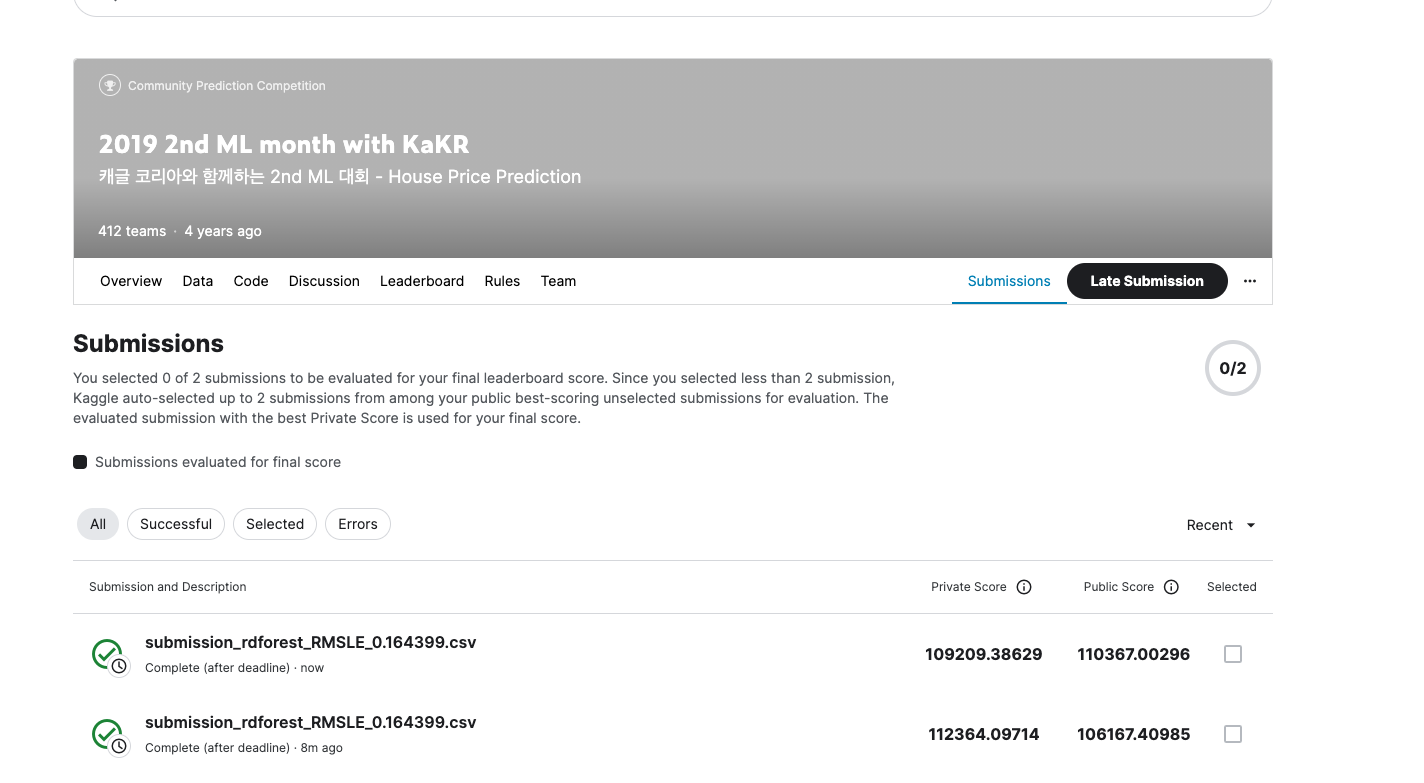

XGBRegressor, GradientBoostingRegression - 8:2 의 경우 109209 / 110367.00296
                                            9:1 의 경우 112364 / 106167